In [2]:
import pyclesperanto_prototype as cle
from skimage.io import imread
import numpy as np

cle.select_device("amd")

<gfx90c on Platform: AMD Accelerated Parallel Processing (2 refs)>

In [3]:
raw = cle.push(imread("C:/structure/data/netosis_deskew/netosis_ch2.tif")[:,:,0:500])
#raw = cle.push(imread("D:\\netosis_ch2.tif")[:,:,0:500])
raw.shape

(834, 300, 500)

yz


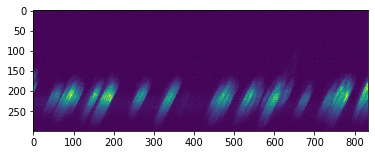

xz


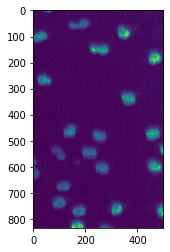

xy


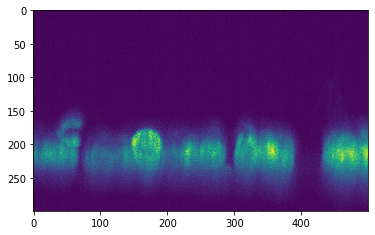

In [6]:
print("yz")
cle.imshow(cle.maximum_x_projection(raw))
print("xz")
cle.imshow(cle.maximum_y_projection(raw))
print("xy")
cle.imshow(cle.maximum_z_projection(raw))

### Transformations:
* Shearing
* Rotation
* Scaling
* Translation (if the stack is outside the bounds of the canvas/FOV after the transformations)

As Deskewing is in the Y direction, you need to calculate Y dimension of the deskewed array first and create a new array with that shape
The rotation matrix should be defined using this new shape. 

So, first we determine the affine matrices and apply it to our coordinates to figure out the new coordinate system. 
We can calculate the new Y shape from the new array




yz:


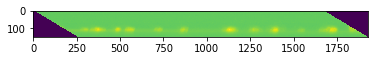

xz:


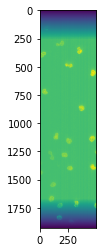

xy:


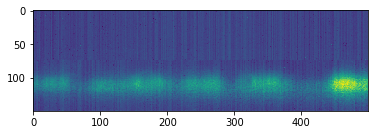

In [18]:
def affine_transform(source, at:cle.AffineTransform3D=None):
    """
    Applies an AffineTransform3D to a given soure image. What's different to the affine_transform in clesperanto:
    Assuming the transform rotates the image out of the field of view (negative coordinates), it will be moved back 
    so that all pixels are visible. Thus, the applied transform actually contains a translation, that was not passed
    as parameter.
    """
    
    # define coordinates of all corners of the current stack
    from itertools import product
    nx,ny,nz=source.shape
    original_bounding_box=[list(x)+[1] for x in product((0,nz),(0,ny),(0,nx))] 
    # transform the corners using the given affine transform
    transformed_bounding_box=np.asarray(list(map(lambda x:at._matrix@x,original_bounding_box)))

    # the min and max coordinates tell us from where to where the image ranges (bounding box)
    min_coordinate = transformed_bounding_box.min(axis=0)
    max_coordinate = transformed_bounding_box.max(axis=0)
    # determin the size of the transformed bounding box
    new_size =(max_coordinate - min_coordinate)[0:3].astype(int).tolist()[::-1]

    # create a new stack on GPU
    destination = cle.create(new_size)
    
    # we make a copy to not modify the original transform
    transform_copy = cle.AffineTransform3D()
    transform_copy._concatenate(at._matrix)
    
    # if the new minimum-coordinate is `-x`, we need to 
    # translate the stack by `x` so that the new origin is (0,0,0)
    translation = -min_coordinate
    transform_copy.translate(
        translate_x = translation[0],
        translate_y = translation[1],
        translate_z = translation[2]
    )

    # apply transform and return result
    return cle.affine_transform(source, destination, transform=transform_copy)
    

def deskew_y(raw, rotation_angle : float = 30):
    """
    Deskew an image stack.
    """
    
    # from https://github.com/SpimCat/unsweep/blob/6592b2667bda304336360e099ac015654a87787a/src/main/java/net/haesleinhuepf/spimcat/unsweep/Unsweep.java#L45
    import math
    deskew_factor = 1.0 / math.tan(rotation_angle * math.pi / 180);
    
    deskew_transform = cle.AffineTransform3D()
    # shearing
    shear_mat = np.array([
                        [1.0, 0 ,0 , 0],
                        [0, 1.0, deskew_factor, 0],
                        [0, 0, 1.0, 0],  
                        [0, 0.0, 0.0, 1.0]          
                        ])
    deskew_transform._concatenate(shear_mat)
    
    # rotation
    deskew_transform.rotate(angle_in_degrees=90-rotation_angle, axis=0)
    
    # apply transform
    return affine_transform(raw, at=deskew_transform)

transformed = deskew_y(raw)

print("yz:")
cle.imshow(cle.mean_x_projection(transformed))
print("xz:")
cle.imshow(cle.mean_y_projection(transformed))
print("xy:")
cle.imshow(cle.mean_z_projection(transformed))

In [ ]:
import napari
viewer = napari.Viewer()

#viewer.add_image(new_dim)
viewer.add_image(transformed)